In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.stats import uniform

# Homework 2 (5)

## (A) Image selection

Take a photograph of a natural environment. This image is denoted as $S(x, y)$. Here $x$ and $y$ are the coordinates of the image pixel locations. For example $x = 1, 2, \dots, 256$ and $y = 1, 2, \dots, 256$. You may find some examples online, or one of your own photographs. An example is the image of peppers in Figure 2. If the original image is colored, remove the color. Plot out the image as a luminance image.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap = "gray")
    plt.colorbar(fraction = 0.046, pad = 0.04)
    plt.show()

In [3]:
insect = imread("resources/left.png")

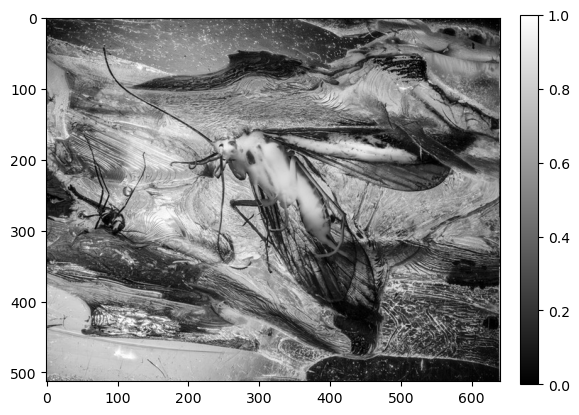

In [4]:
plot_image(insect)

## (B) Rescale the image

Transform the image to make it zero mean for convenience. Hence, get the pixel value average $\hat{S} = \sum_{x, y}\ \frac{S(x, y)}{N}$, where $N$ is the total number of pixels in this image.  Then make $S(x, y) \rightarrow S(x, y) - \hat{S}$. Now $S(x, y)$ has zero mean value across the image.

In [5]:
insect = insect - np.mean(insect)

print(f"Mean: {round(np.mean(insect), 5)}")

Mean: 0.0


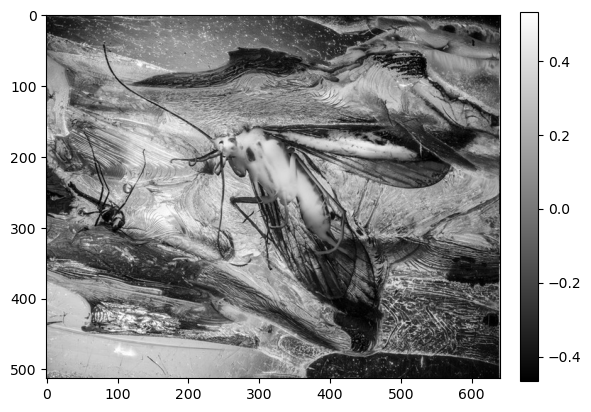

In [6]:
plot_image(insect)

## (C) Correlation

Observe how neighboring pixels are correlated with each other in their luminance values. For example, if you have one pixel at $(x, y)$ and another at $(x + d, y)$, these two pixels are horizontally displaced by a distance $d$. Calculate

$$
R^S(d) = \sum_{x, y}\ \frac{S(x, y) S(x + d, y)}{N'}
$$

where $N'$  the total number of pairs of pixels that you include in your sum $\sum_{x, y}$. Note that some pixels $(x, y)$ are too close to the edge of the images that $(x + d, y)$ in not included in the image. This $R^S(d)$ approximates the correlation as a function of $d$. Try to calculate for a number of different $d$ values, and see how $R^S(d)$ decays with $d$. Take a moment to consider what this entails for efficient coding of such images. (Many programming languages have routines for calculating correlations, e.g., in Matlab, you have xcorr().)

In [7]:
def pixel_correlation(image, max_d):
    height, width = image.shape
    corr = np.zeros(max_d)
    N_prime = 0

    for d in range(1, max_d + 1):
        sum_corr = np.sum(image[:, :-d] * image[:, d:])
        num_pairs = (height * (width - d))

        N_prime += num_pairs
        corr[d - 1] = sum_corr / N_prime

    # Scale
    corr = (corr - np.min(corr)) / (np.max(corr) - np.min(corr))
    return corr

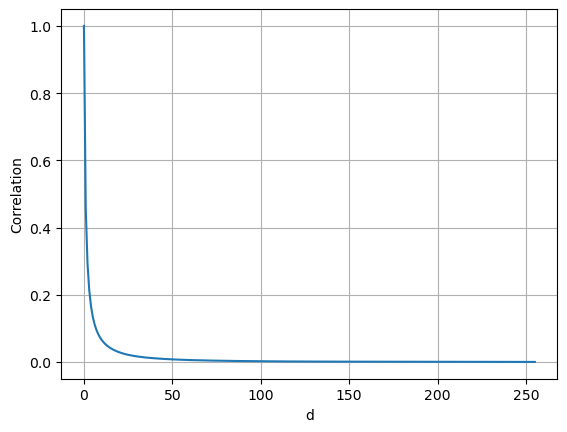

In [8]:
corr = pixel_correlation(insect, max_d = round(insect.shape[0] / 2))

plt.plot(corr)
plt.xlabel("d")
plt.ylabel("Correlation")
plt.grid()
plt.show()

## (D) Fourier power spectrum

If you have not yet done it in your previous exercise, calculate a Fourier power spectrum. Let us practice just a simplified version. Let $L$ be the range of $x$ values of your image pixels $(x, y)$. Then, take Fourier frequency $k$ as one of these discrete values,

$$
k = \frac{n\ \cdot \ 2 \pi}{L}
$$

using $(L + 1)$ integer values $n = 0, 1, 2, \dots, L$, (this $k$ is in the unit of radian/pixel) and calculate

$$
S_c(k) = \sum_{x,y}S(x, y)cos(kx)
$$

$$
S_s(k) = \sum_{x,y}S(x, y)sin(kx)
$$

Then the signal power for this Fourier frequency $k$ is (up to a scale constant)

$$
|S(k)|^2 = [S_c(k)]^2 + [S_s(k)]^2
$$

Plot out $|S(k)|^2$ as a function of $k$. For typical photographs of natural scenes, $|S(k)|^2$ decays with $k$ as $1/k^2$. To see the results clearly, use log scale on both the vertical and horizontal axes, like in the lower left panel in Figure 2.

You may like to average $|S(k)|^2$ over multiple images (make all images the same size for convenience) to see the trend of $|S(k)|^2$ versus $k$ more clearly.

In [9]:
def g_c(kernel, k):
    res = 0

    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            pos = j
            res += kernel[i, j] * np.cos(k * pos)

    return res

In [10]:
def g_s(kernel, k):
    res = 0

    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            pos = j
            res += kernel[i, j] * np.cos(k * pos)

    return res

In [11]:
def power_spectrum(image, k):
    g_k = []
    for _k in k:
        gs = math.pow(g_s(image, _k), 2)
        gc = math.pow(g_c(image, _k), 2)
        g_k.append(gs + gc)

    return g_k

In [12]:
def k_step(pixels):
    return [ n * 2 * math.pi / pixels for n in range(0, int(pixels / 2)) ]

In [13]:
ks = k_step(insect.shape[0])
sk = power_spectrum(insect, ks)

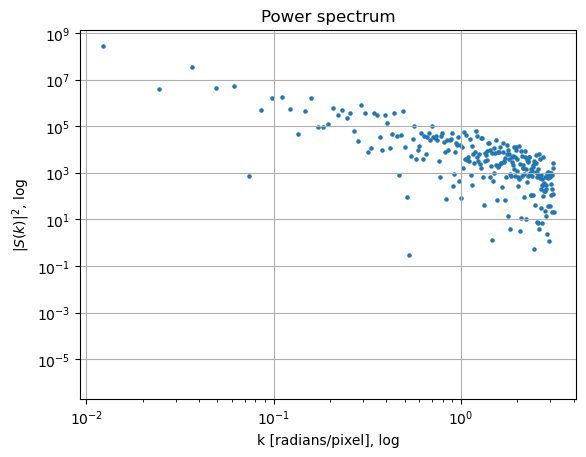

In [14]:
plt.scatter(ks, sk, s = 5)
plt.grid()
plt.xlabel("k [radians/pixel], log")
plt.ylabel(r"$|S(k)|^2$, log")
plt.xscale("log")
plt.yscale("log")
plt.title("Power spectrum")
plt.show()

## (E) Fourier transform

The steps in (D) only looked at Fourier frequencies for a Fourier wave that is vertical, so the frequency $k$ is along the horizontal or $x$ direction. However, the Fourier wave can be in any direction. So the frequency $k$ should be a vector with a horizontal component $k_x$ and a vertical component $k_y$, so that the magnitude $k = \sqrt{k_x^2 + k_y^2}$. Then, for each image $S(x, y)$, which span horizontally in $x$ and vertically in $y$, one can obtain its Fourier component $S(k)$ for vector frequencies $k$. Usually, your programming language has a routine for Fourier transform, try to use it to get $S(k)$.

In [15]:
fourier_transform = np.fft.fft2(insect)
centered_spectrum = np.fft.fftshift(fourier_transform)
magnitude_spectrum = np.abs(centered_spectrum)
inverse_transform = np.fft.ifft2(fourier_transform)

image_height, image_width = insect.shape

frequencies_x = np.fft.fftfreq(image_width) * image_width
frequencies_y = np.fft.fftfreq(image_height) * image_height

shifted_frequencies_x = np.fft.fftshift(frequencies_x)
shifted_frequencies_y = np.fft.fftshift(frequencies_y)

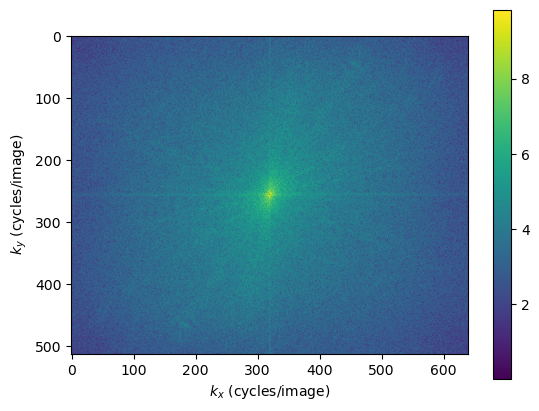

In [16]:
plt.imshow(np.log1p(magnitude_spectrum))
plt.xlabel(r"$k_x$ (cycles/image)")
plt.ylabel("$k_y$ (cycles/image)")
plt.colorbar()
plt.show()

## (F) Fourier power spectrum of a noisy image

In (D) and (E), you may find that your power spectrum, the $|S(k)^2|$ versus $k$, does not decay with $k$ in a way expected when $k$ is very large. This may be because your image is noisy, so that $|S(k)^2|$ include the power of the white noise. However, if your image is not noisy enough, or to practice seeing the effect of noise on $|S(k)^2|$, let us make the image noisy by adding noise as follows

$$
S(x, y) \rightarrow S(x, y) + N(x, y)
$$

in which $N(x, y)$ is a noise image. For each pixel $(x, y)$, make $N(x, y)$ a zero-mean random nubmer $-N_{max} \leq N(x, y) \leq N_{max}$ with a maximum magnitude $N_{max}$. Make $N_{max}$ large enough so that the noise is obvious. Plot out this noisy image. You can see an example of such a noisy image in Figure 4A. Once you get this noisy image, repeat (D) to plot $|S(k)^2|$ versus $k$, and see whether $|S(k)^2|$ versus $k$ behaves like the blue curve in Figure 4B, and try to understand the result.

In [17]:
def noise(nmax = 1, n = 1):
    return uniform.rvs(loc = -nmax, scale = nmax, size = n)

In [18]:
def noisy_image(original, nmax = 1):
    noise_data = np.reshape(noise(nmax, n = np.size(original)), newshape = original.shape)
    return original + noise_data

In [19]:
noisy_insect = noisy_image(insect, nmax = 1.5)

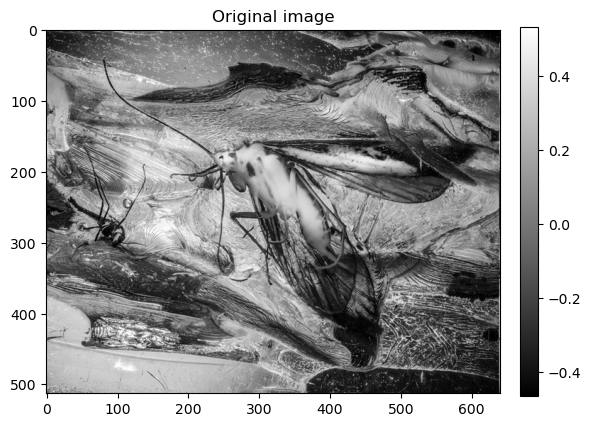

In [20]:
plt.title("Original image")
plot_image(insect)

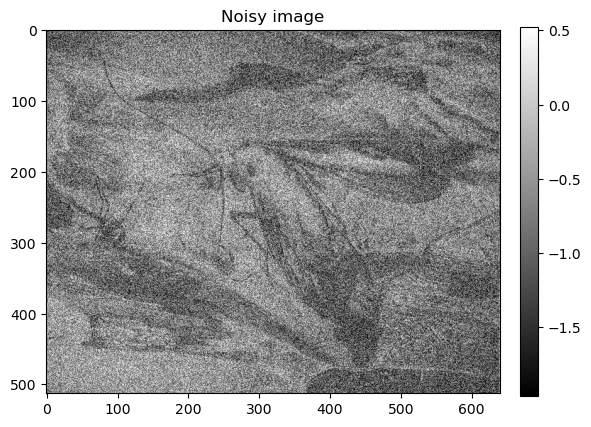

In [21]:
plt.title("Noisy image")
plot_image(noisy_insect)

In [22]:
ks = k_step(noisy_insect.shape[0])
sk = power_spectrum(noisy_insect, ks)

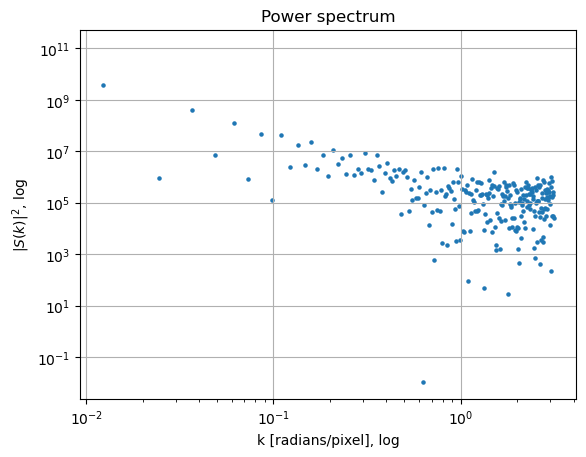

In [23]:
plt.scatter(ks, sk, s = 5)
plt.grid()
plt.xlabel("k [radians/pixel], log")
plt.ylabel(r"$|S(k)|^2$, log")
plt.xscale("log")
plt.yscale("log")
plt.title("Power spectrum")
plt.show()

## (G) Gain control of the Fourier components

Going from the image $S$ to its Fourier components $S(k)$ is the principal component transform on the image. For efficient coding, we need to give gain control $g(k)$ to each component $S(k)$ as the second step in the efficient coding recipe. This gives

$$
O(k) = g(k) S(k)
$$

This $g(k)$ should be

$$
g(k) = (|k| + |k_o|) \times exp(- \frac{|k|^2}{k^2_{low}})
$$

in which $k_o$ and $k_{low}$ are parameters. The first factor $(|k| + |k_o|)$ is a whitening filter,
useful for low input noise conditions. Typically, $k_o$ is very small, you could make $k_o = 0$ or just non-zero small number. The second factor $exp(- \frac{|k|^2}{k^2_{low}})$ is a low-pass low filter, to avoid sending too much noise when signal-to-noise is too low for large $|k|$. Try to make $k_{low}$ at a $|k|$ value where the signal and noise power are comparable, this is where $|S(k)|^2$ stop the trend of decaying with $|k|$.

Then, you do the inverse Fourier transform on $O(k)$ and plot the results. Play with different values for $k_{low}$ and see what you get as the results. Compare with the plots in Figure 4CDE.


In [24]:
def gain_filter(image_shape, k_o, k_low):
    height, width = image_shape
    freq_x, freq_y = np.meshgrid(np.fft.fftfreq(width), np.fft.fftfreq(height))
    frequency_magnitude = np.sqrt(freq_x**2 + freq_y**2)
    return (np.abs(frequency_magnitude) + np.abs(k_o)) * \
        np.exp(-frequency_magnitude**2 / k_low**2)

In [25]:
fourier_transform = np.fft.fft2(noisy_insect)

In [26]:
k_o = 1e-3
k_low_values = [0.06, 0.1, 0.025]

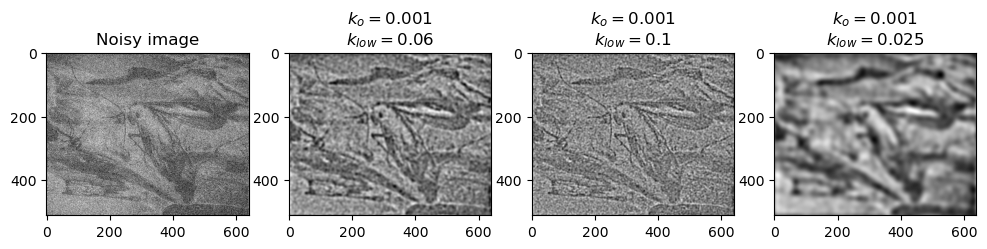

In [27]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 4, 1)
plt.imshow(noisy_insect, cmap = "gray")
plt.title("Noisy image")

for i, k_low in enumerate(k_low_values):
    g_k = gain_filter(noisy_insect.shape, k_o, k_low)
    O_k = g_k * fourier_transform

    filtered_image = np.fft.ifft2(O_k)
    filtered_image = np.real(filtered_image)

    plt.subplot(1, 4, i + 2)
    plt.imshow(filtered_image, cmap = "gray")
    plt.title(r"$k_o = $" + f"{k_o}" + "\n" + r"$k_{low} = $" + f"{k_low}")

plt.show()